In [196]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
from four_point_transform import four_point_transform

In [197]:
def draw(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')

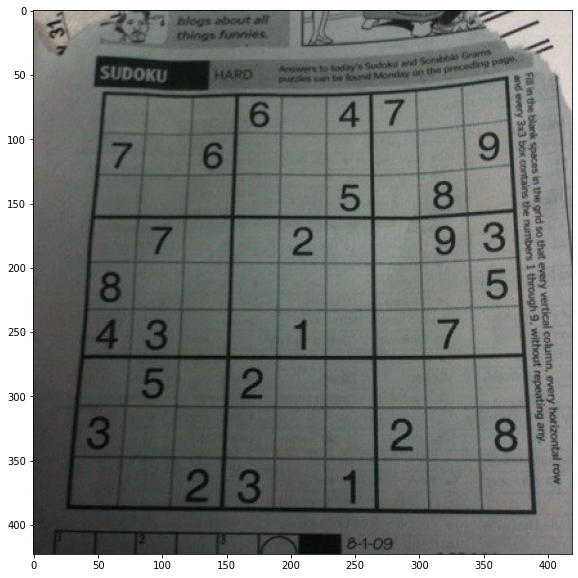

In [198]:
src = 'sudoku.jpeg'
img = cv2.imread(src)
draw(img)

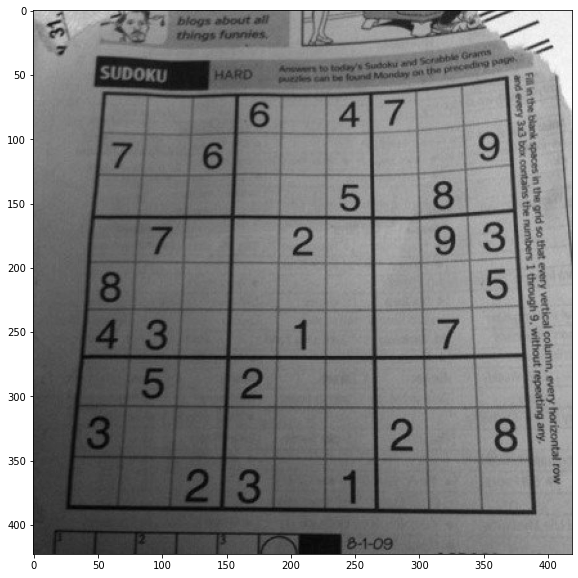

In [199]:
# Convert image to grayscale.
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
draw(gray)

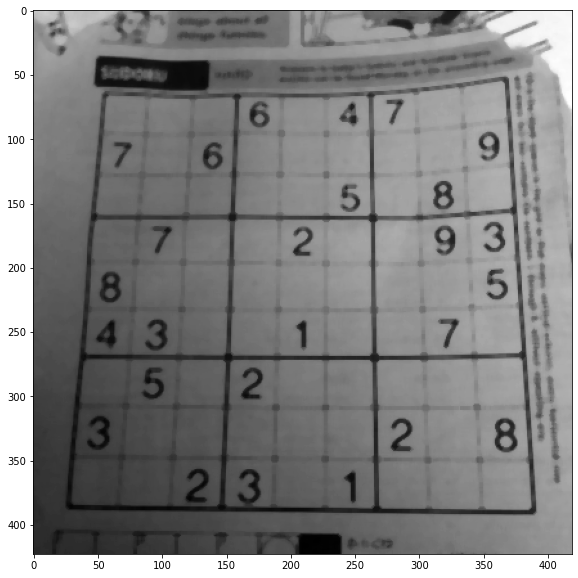

In [200]:
# Smooth image by applying median blur.
blur = cv2.medianBlur(gray, 5)
draw(blur)

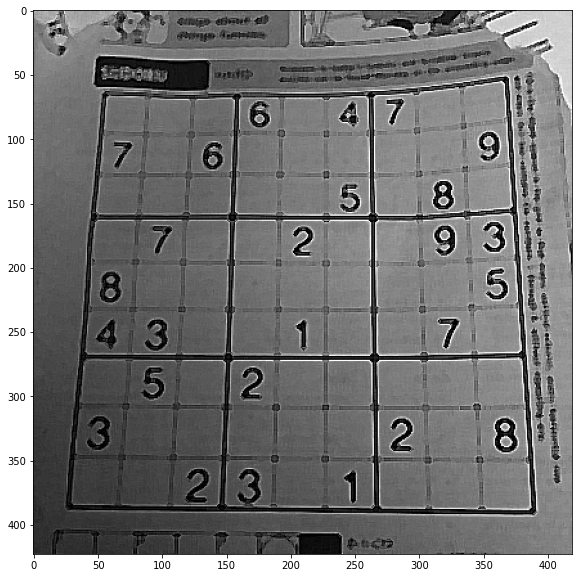

In [201]:
# Sharpen image to enhance edges.
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(blur, -1, sharpen_kernel)
draw(sharpen)

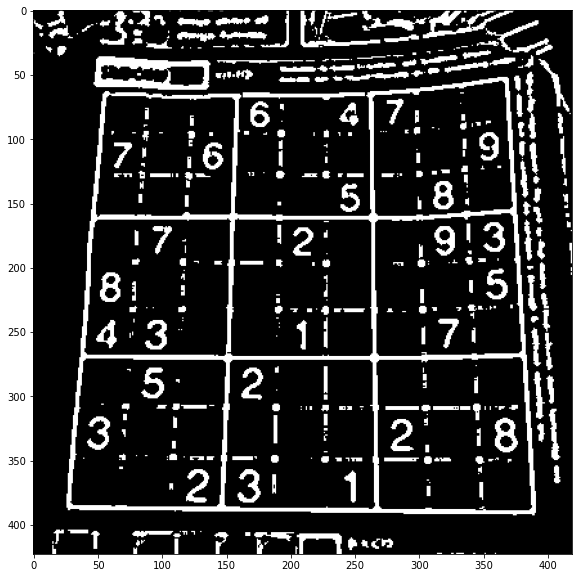

In [308]:
block_size=15
c=5
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, c)
draw(thresh)

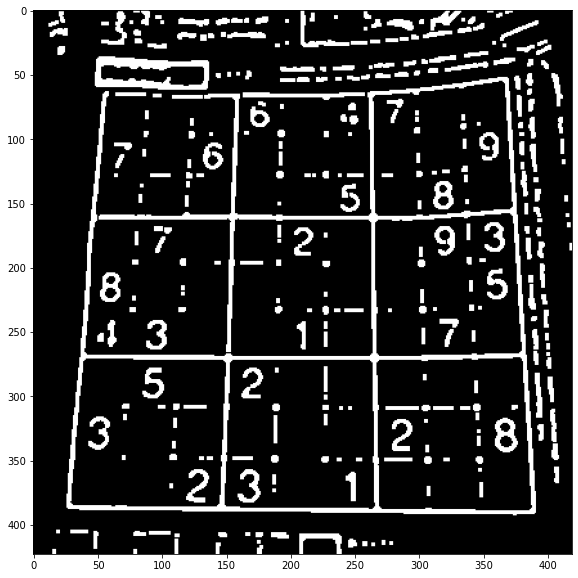

In [321]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
close = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
draw(close)

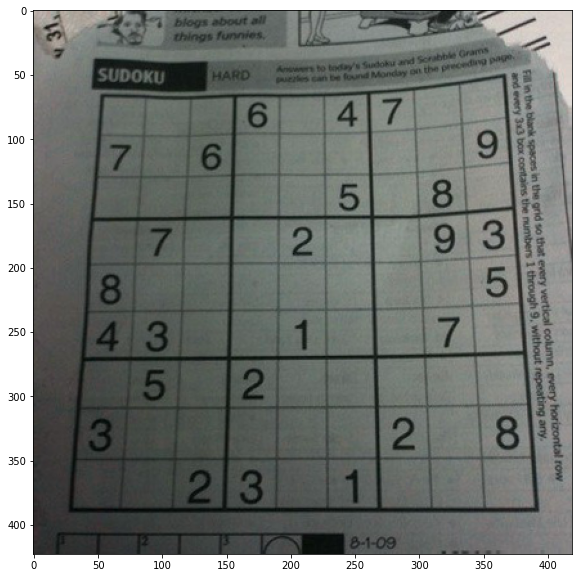

In [322]:
# NOTE: This method of finding contour does not solve for warped boxes.
# Find all contours.
def getSkewAngle(img):
    img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 3)
    block_size=15
    c=5
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, c)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)

    contours, hierarchy = cv2.findContours(close, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find contours with the largest area.
    contours = sorted(contours, key=cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largest_contour = contours[0]
    min_area_rect = cv2.minAreaRect(largest_contour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = min_area_rect[-1]
    if angle < -45:
        angle = 90 + angle
    return angle

# Rotate the image around its center
def rotateImage(img, angle: float):
    img = img.copy()
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    out = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return out

# Deskew image
def deskew(img):
    img = img.copy()
    angle = getSkewAngle(img)
    return rotateImage(img, angle)

draw(deskew(img))

# Draw border.
# x, y, w, h = cv2.boundingRect(contours[0])
# target = rotated_img[y:y+h,x:x+w].copy()
# cv2.rectangle(target, (0, 0), (w, h), (36,255,12), 2)
# draw(target)

# out = img.copy()
# cv2.rectangle(out, (x, y), (x+w, y+h), (36,255,12), 2)
# draw(out)

# cropped = gray[y:y+h,x:x+w].copy()

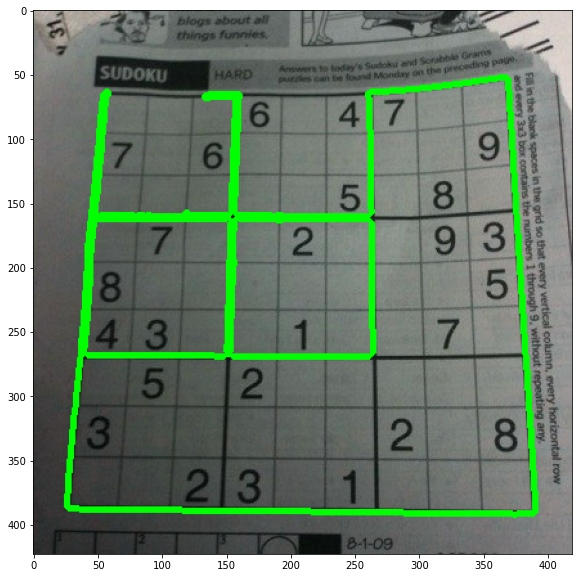

In [349]:
# Finding warped contours.
contours, hierarchy = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find contours with the largest area.
contours = sorted(contours, key=cv2.contourArea, reverse = True)
max_contour = contours[0]

out = img.copy()
cv2.drawContours(out, [max_contour], -1, (0, 255, 0), 3)
draw(out)
# # loop over our contours
# for c in contours:
#     # Approximate the contour
#     peri = cv2.arcLength(c, True)
#     approx = cv2.approxPolyDP(c, 0.02 * peri, True)
#     # if our approximated contour has four points, then
#     # we can assume that we have found our screen
#     if len(approx) == 4:
#         box_contour = approx
#         out = img.copy()
#         cv2.drawContours(out, [box_contour], -1, (0, 255, 0), 3)
#         draw(out)
#         box_contour = None
#         break

## 